In [1]:
import copy

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torch.nn as nn
from torchvision.transforms import v2
import multiprocessing
import torch.nn.utils.prune as prune
import torch.nn.functional as F


In [2]:
print(torch.cuda.is_available())

True


In [3]:
# run variables

seed = 42
file_name = 'base_pruned'
# file_name = 'student_self_taught'

class BaseNN(nn.Module):
    def __init__(self, conv1_out = 128, conv2_out = 64, conv3_out = 32, num_classes=10):
        super(BaseNN, self).__init__()

        ### teacher
        self.features = nn.Sequential(
            nn.Conv2d(3, conv1_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(conv1_out, conv2_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(conv2_out, conv2_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(conv2_out, conv3_out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

        ### student
        # self.features = nn.Sequential(
        #     nn.Conv2d(3, 16, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     nn.Conv2d(16, 16, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        # )
        # self.classifier = nn.Sequential(
        #     nn.Linear(1024, 256),
        #     nn.ReLU(),
        #     nn.Dropout(0.1),
        #     nn.Linear(256, num_classes)
        # )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
# device settings

num_workers = 2

print(torch.cuda.get_device_name(torch.cuda.current_device()))

#device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

NVIDIA GeForce RTX 2060
Using cuda device


In [5]:
# define datasets and loaders

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = torchvision.datasets.CIFAR10("./../data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10("./../data", train=False, transform=transform, download=True)

train_dataset, validation_dataset =  random_split(train_dataset, [0.8, 0.2])

print('train set size:', len(train_dataset))
print('validation set size:', len(validation_dataset))
print('test set size:', len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=num_workers)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=num_workers)

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Files already downloaded and verified
Files already downloaded and verified
train set size: 40000
validation set size: 10000
test set size: 10000


In [6]:
def train(model, epochs, learning_rate):
    trainingEpoch_loss = []
    validationEpoch_loss = []
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        # training
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        trainingEpoch_loss.append(running_loss / len(train_loader))

        # validation
        model.eval()
        validation_loss = 0.0
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item()

        validationEpoch_loss.append(validation_loss / len(validation_loader))

    return trainingEpoch_loss, validationEpoch_loss

In [7]:
def test(model):
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [8]:
torch.manual_seed(seed)
model_base = BaseNN(num_classes=10).to(device)


In [9]:
trainingEpoch_loss, validationEpoch_loss = train(model_base, epochs=10, learning_rate=0.001)

Epoch 1/10, Loss: 1.3935775758743285
Epoch 2/10, Loss: 0.9089925354957581
Epoch 3/10, Loss: 0.7178989406585693
Epoch 4/10, Loss: 0.5670861113548279
Epoch 5/10, Loss: 0.4369517149209976
Epoch 6/10, Loss: 0.32411869415044786
Epoch 7/10, Loss: 0.2390675737321377
Epoch 8/10, Loss: 0.19385855768918991
Epoch 9/10, Loss: 0.1528088714286685
Epoch 10/10, Loss: 0.13444784644395114


In [10]:
test(model_base)

Test Accuracy: 74.16%


74.16

In [21]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

In [23]:
total, trainable = count_parameters(model_base)

print(f"📦 Liczba wszystkich parametrów: {total}")

📦 Liczba wszystkich parametrów: 1186986


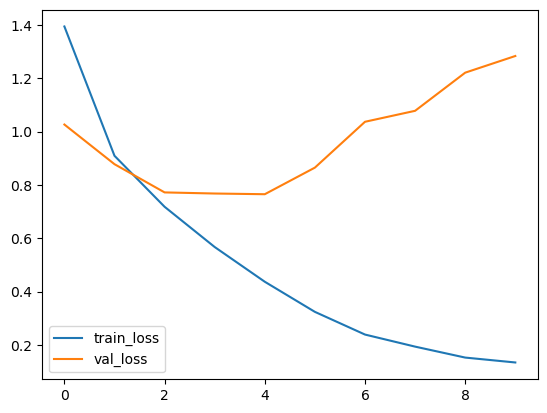

In [11]:
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show()

In [12]:
# === Sparsity ===
def calculate_sparsity(model):
    zero, total = 0, 0
    for p in model.parameters():
        total += p.numel()
        zero += (p == 0).sum().item()
    return 100.0 * zero / total

In [33]:
# === Unstructured pruning ===
unstructured_model = copy.deepcopy(model_base)
prune.l1_unstructured(unstructured_model.classifier[0], name='weight', amount=0.8)
prune.l1_unstructured(unstructured_model.classifier[3], name='weight', amount=0.8)

prune.l1_unstructured(unstructured_model.features[0], name='weight', amount=0.8)
prune.l1_unstructured(unstructured_model.features[2], name='weight', amount=0.8)

print(f"Sparsity: {calculate_sparsity(unstructured_model):.2f}%")

# === Usuwanie masek pruningowych ===
for module in [unstructured_model.classifier[0], unstructured_model.classifier[3], unstructured_model.features[0], unstructured_model.features[2]]:
    prune.remove(module, 'weight')

print(f"Sparsity: {calculate_sparsity(unstructured_model):.2f}%")


Sparsity: 0.00%
Sparsity: 76.22%


In [34]:
trainingEpoch_loss, validationEpoch_loss = train(unstructured_model, epochs=3, learning_rate=0.001)

Epoch 1/3, Loss: 0.24053179274201394
Epoch 2/3, Loss: 0.13655116394162178
Epoch 3/3, Loss: 0.11108614333719015


In [35]:
test(unstructured_model)

Test Accuracy: 74.29%


74.29

In [36]:
def count_nonzero_parameters(model):
    total_nonzero = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            total_nonzero += (param != 0).sum().item()
    return total_nonzero

In [37]:
total, trainable = count_parameters(unstructured_model)

print(f"📦 Liczba wszystkich parametrów: {total}")

📦 Liczba wszystkich parametrów: 1186986


In [38]:
zeros_weight_count = count_nonzero_parameters(unstructured_model)
print(f"📦 Liczba niezerowych parametrów: {zeros_weight_count}")

📦 Liczba niezerowych parametrów: 753565


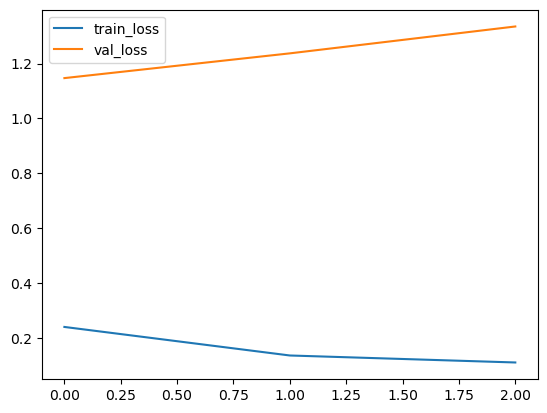

In [39]:
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show()

In [40]:
torch.save(unstructured_model.state_dict(), "../models/" + "unstructured_model" + ".pt")

In [41]:
# === Structured pruning - kanały Conv2d ===
def get_pruned_channels(conv_layer, amount):
    weight = conv_layer.weight.detach().cpu()
    norms = weight.view(weight.size(0), -1).norm(p=2, dim=1)
    num_prune = int(amount * weight.size(0))
    keep_indices = torch.argsort(norms)[num_prune:]
    return keep_indices.tolist()

In [42]:
# Pruning 50% kanałów pierwszej i drugiej warstwy konwolucyjnej
keep1 = get_pruned_channels(model_base.features[0], amount=0.5)
keep2 = get_pruned_channels(model_base.features[2], amount=0.5)
structured_model = BaseNN(conv1_out=len(keep1), conv2_out= len(keep2)).to(device)

In [43]:
trainingEpoch_loss, validationEpoch_loss = train(structured_model, epochs=10, learning_rate=0.001)

Epoch 1/10, Loss: 1.4144269971847534
Epoch 2/10, Loss: 0.9745868720054627
Epoch 3/10, Loss: 0.77206976313591
Epoch 4/10, Loss: 0.6187857872009277
Epoch 5/10, Loss: 0.4866355870962143
Epoch 6/10, Loss: 0.3629067531108856
Epoch 7/10, Loss: 0.2678003911137581
Epoch 8/10, Loss: 0.19920517013072966
Epoch 9/10, Loss: 0.1668464062511921
Epoch 10/10, Loss: 0.14616774046421052


In [44]:
test(structured_model)

Test Accuracy: 70.84%


70.84

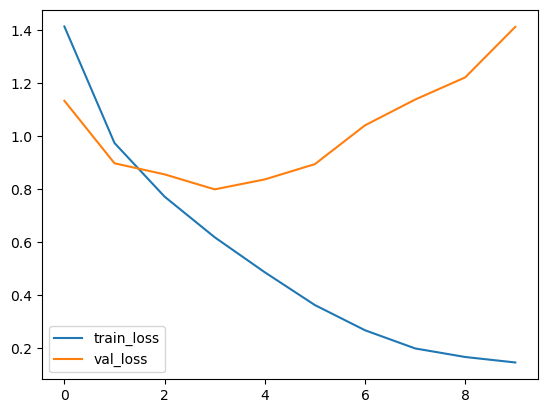

In [45]:
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show()

In [46]:
torch.save(structured_model.state_dict(), "../models/" + "structured_model" + ".pt")